# SubSection Management Functions

## Setup

### Imports

In [2]:

from typing import Any
from typing import Dict, List, NamedTuple, TypeVar
from typing import Iterable, Any, Callable, Union, Generator
from typing import Tuple


import re
from pprint import pprint
from functools import partial
from abc import ABC, abstractmethod

from sections import Section
from sections import SectionBreak
from buffered_iterator import BufferedIterator
from sections import set_method, Rule, RuleSet
from sections import ProcessingMethods

### Typing

In [3]:
#%% Input and output Type Definitions
SourceItem = Any
Source = Iterable[SourceItem]
# SourceOptions can be single SourceItem or an iterable of SourceItems.
SourceOptions = Union[SourceItem, Source]
# 1 or more ProcessMethods applied to SourceItems result in ProcessedItems
#   1 SourceItem ≠1 ProcessedItem;
#	  • 1 SourceItem → 1 ProcessedItem
#	  • 1 SourceItem → 2+ ProcessedItems
#	  • 2+ SourceItems → 1 ProcessedItem;
ProcessedItem = Any
ProcessedList = List[ProcessedItem]
ProcessOutput = Union[ProcessedItem, ProcessedList]
ProcessedItemGen = Generator[ProcessedItem, None, None]
ProcessedItems = Union[ProcessedItem, ProcessedItemGen]
# Assembled section converts a ProcessedItems into a single Assembled Item.
AssembledItem = Any
# Assembled SubSection group
SubSectionGroupItem = Dict[str, AssembledItem]


#%% Context Type
# Context Provides a way to pass information between sections.
# Context can be used to pass additional parameters to functions.
ContextType = Union[Dict[str, Any], None]

#%% Relevant Callable Type definitions for Process and Rule functions.
# Sentinel and Process Functions
# Sentinel and Process Functions can function that can act on a SourceItem
# provided the function signature is one of the following:
#   Callable[[SourceItem], ProcessedItem]
#   Callable[[SourceItem, ContextType], ProcessedItem]
#   Callable[[SourceItem, ...], ProcessedItem]
#       Where ... represents keyword arguments
ProcessFunc = Callable[[SourceItem, ContextType], ProcessedItems]
ProcessCallableOptions = Union[ProcessFunc,
                               Callable[[SourceItem], ProcessedItems],
                               Callable[..., ProcessedItems]]
# Rule functions
# RuleMethods can take an additional positional argument, the TriggerEvent.
# Supplied RuleMethods can be any Process function and can also have the
# additional positional argument, the TriggerEvent:
#   Callable[[SourceItem, "TriggerEvent"], ProcessedItem]
RuleFunc = Callable[[SourceItem, "TriggerEvent", ContextType], ProcessedItems]
RuleCallableOptions = Union[
    ProcessCallableOptions,
    RuleFunc,
    Callable[[SourceItem, "TriggerEvent"], ProcessedItems],
    ]
# Assemble Functions
# Assemble function are like Process Functions, except they return a single
# item, never a generator.  The function signature must be one of the following:
#   Callable[[ProcessedItems], AssembledItem]
#   Callable[[ProcessedItems, ContextType], AssembledItem]
#   Callable[[ProcessedItems, ...], AssembledItem]
#       Where ... represents keyword arguments
AssembleFunc = Callable[[ProcessedList, ContextType], AssembledItem]
AssembleCallableOptions = Union[AssembleFunc, None,
                               Callable[[ProcessedList], AssembledItem],
                               Callable[..., ProcessedList]]
# SectionCallables describe all possible function types: Sentinel, Process, Rule
# and Assemble.
SectionCallables = Union[ProcessFunc, RuleFunc]


#%% Relevant Type definitions for Trigger Class and SubClasses.
# Sentinels
# Trigger sentinels define tests to be applied to a SourceItem.
# Sentinel types that are independent of the SourceItem are bool and int.
# sentinel=None becomes boolean True (Trigger always passes)
TriggerSingleTypes = Union[None, bool, int]
# Sentinel types that apply to string type SourceItems are str and re.Pattern.
TriggerStringOptions = Union[str, re.Pattern]
# Sentinel can also be any valid Process Functions
# String and Callable sentinel types can also be provided as a list, where if
# any one of the sentinels in the list pass the trigger passes.
TriggerListOptions = Union[TriggerStringOptions, ProcessCallableOptions]
# All possible sentinel types
TriggerTypes = Union[TriggerSingleTypes, TriggerListOptions]
# All possible sentinel types and valid sentinel list types
TriggerOptions = Union[TriggerTypes, List[TriggerListOptions]]
# Applying a trigger gives a TestResult, which can be a boolean, a regular
# expression or the return from a Trigger Sentinel Function (ProcessedItem)
EventType = Union[bool, int, str, re.match, ProcessedItem, None]
TestResult = Union[bool, re.match, ProcessedItem]
TestType = Callable[[TriggerTypes, SourceItem, ContextType], TestResult]
# Relevant Type definitions for SectionBreak Class
OffsetTypes = Union[int, str]
# Relevant Type definitions for Rule and RuleSet Classes
RuleMethodOptions = Union[str, RuleCallableOptions, None]
# Relevant Type definitions for Process Classes
ProcessMethodOptions = Union[str, ProcessCallableOptions, None]
RuleOptions = Union["Rule", "RuleSet"]
SectionOptions = Union["Section", List["Section"]]
ProcessMethodDef = Union[ProcessMethodOptions, RuleOptions, SectionOptions]
ProcessorOptions = Union[ProcessMethodDef, List[ProcessMethodDef]]
ProcessMethodsList = Union[ProcessFunc, "Rule", "RuleSet"]

#%% Relevant Type definitions for Section Classes
BreakOptions = Union["SectionBreak", List["SectionBreak"], str, None]

# A sub-iterable of Source that only iterates over the Section content of Source.
SectionGen = Generator[SourceItem, None, None]



### Test Text

In [4]:
test_text = [
            'Text to be ignored',
            'StartSection A',
            'MiddleSection A',
            'EndSection A',
            'Unwanted text between sections',
            'StartSection B',
            'MiddleSection B',
            'EndSection B',
            'StartSection C',
            'MiddleSection C',
            'EndSection C',
            'Even more text to be ignored',
            ]

short_multi_section_text = [
    'StartSection Name:A',
    'A Content1:a',
    'EndSection Name:A',
    'StartSection Name:B',
    'A Content2:a',
    'EndSection Name:B'
    ]

multi_section_text = [
    'Text to be ignored',
    'StartSection Name:A',
    'A Content1:a',
    'B Content1:b',
    'C Content1:c',
    'EndSection Name:A',
    'StartSection Name:B',
    'A Content2:a',
    'B Content2:b',
    'C Content2:c',
    'EndSection Name:B',
    'Even more text to be ignored',
    ]


## Subsection Requirements
### Context
- Do not change the supplied context
- Use *self.context*
- *self.context* needs to be updated after every stage
- Need to protect standard context items from being changed by sub sections

### Source
- Supplied source needs to be isolated from the iterated source or it may exit too soon.
- Section's source pointer needs to be adjusted so that any "Future Items" are not missed.
- Both context and iterator should be isolated by default 


## Functions for subsections

In [5]:
def true_iterable(variable)-> bool:
    '''Indicate if the variable is a non-string type iterable.
    Arguments:
        variable {Iterable[Any]} -- The variable to test.
    Returns:
        True if variable is a non-string iterable.
    '''
    return not isinstance(variable, str) and isinstance(variable, Iterable)  # pylint: disable=isinstance-second-argument-not-valid-type



### Check for empty object

In [6]:
def is_empty(obj: Any)->bool:
    '''Test whether an object is empty.

    If object is None, it is empty.
    If object has length 0 it is empty.
    Otherwise it is not empty.

    Args:
        obj (Any): The object to be tested

    Returns:
        bool: Returns true if the object is empty.
    '''
    if obj is None:
        return True
    try:
        has_length = len(obj)
    except TypeError as err:
            return False
    else:
        if has_length == 0:
            return True
        else:
            return False

### Read a subsection

In [7]:
def read_subsection(subsection: 'Section',
                    source: ProcessedItemGen,
                    context: ContextType = None
                    ) -> Generator[AssembledItem, None, None]:
    '''Iterate through the supplied source returning the assembled subsection.

    This method is used when individual subsections are used as
    ProcessingMethods.

    Args:
        subsection ('Section'): The sub-section object
            ('Section' is a subclass of BaseSection)
        source (ProcessedItemGen): The iterator resulting from applying
            zero or more processing functions to the original source.
        context (ContextType, optional): Break point information and any
            additional information to be passed to and from the
            sub-section instance. Defaults to None.
    Yields:
        Generator[AssembledItem, None, None]: The result of applying the
            subsection.read method repeatedly to the supplied source.
    '''
    done = False
    while not done:
        section_item = subsection.read(source, context=context)
        yield section_item
        # Generator exits are captured by the read method.
        # subsection.scan_status provides an indication of whether the
        # iterator has been exhausted.
        if subsection.scan_status in ['Scan Complete', 'End of Source']:
            done=True

### Read a list of subsections as a group

In [8]:
def assemble_subsection_group(subsection_group: Tuple['Section'],
                        source: ProcessedItemGen,
                        context: ContextType = None
                        )->SubSectionGroupItem:
    '''Build the assembled subset group from the supplied source

    Sequentially applies the read() method of each Section object in
    subsection_group to the supplied source, generating a dictionary where
    the key is the section name and the value is the AssembledItem returned
    by the read() method.

    Args:
        subsection_group (Tuple['Section']): The sequence of Section object
            to be read from the source. ('Section' is a subclass of
            BaseSection).
        source (ProcessedItemGen): The iterator resulting from applying
            zero or more processing functions to the original source.
        context (ContextType, optional): Break point information and any
            additional information to be passed to and from the
            sub-section instance. Defaults to None.

    Returns:
        SubSectionGroupItem: _description_
    '''
    # Repeat until source is exhausted
    done = False
    while not done:
        section_group = {}
        for sub_section in subsection_group:
            sub_section_item = sub_section.read(source, context=context)
            # Generator exits are captured by the read method.
            if sub_section.scan_status in ['Scan Complete', 'End of Source']:
                if not is_empty(sub_section_item):
                    # Don't return empty read results.
                    section_group[sub_section.name] = sub_section_item
                # Break if end of source reached
                done = True
                break
            # Always store read result if subsection did not close
            section_group[sub_section.name] = sub_section_item
        if is_empty(section_group):
            # Don't return empty section group.
            yield None
        else:
            yield section_group


In [9]:
## Single line subsections
name_section = Section(
    name='Name',
    start_section=SectionBreak('StartSection', name='NameStart'),
    end_section=SectionBreak(True, name='NameEnd')
    )

content_section = Section(
    name='Content',
    end_section=SectionBreak('EndSection', 
                             break_offset='Before', 
                             name='EndContent')
    )

end_section = Section(
    name='End',
    end_section=SectionBreak(True, name='EndEnd')
    )


### Check individual subsections

In [10]:
test_iter = BufferedIterator(multi_section_text)

print(name_section.read(test_iter),'\n')

print(content_section.read(test_iter),'\n')

print(end_section.read(test_iter),'\n')

print(repr(test_iter))

['StartSection Name:A'] 

['A Content1:a', 'B Content1:b', 'C Content1:c'] 

['EndSection Name:A'] 

BufferedIterator(source=<list_iterator object at 0x000002749B9FCD00>, buffer_size=5)
	BufferedIterator.previous_items = deque(['A Content1:a', 'B Content1:b', 'C Content1:c', 'EndSection Name:A'], maxlen=5)
	BufferedIterator.future_items = deque(['StartSection Name:B'], maxlen=5)
	BufferedIterator.item_count = 6
	BufferedIterator.status = ACTIVE


### Single Line Subsections as a group

In [11]:
section_list = (name_section, content_section, end_section)

In [12]:
test_iter = BufferedIterator(multi_section_text)
context = {'dummy': 'asdf'}

combined_sections = [grp for grp in assemble_subsection_group(section_list,
                                                              test_iter,
                                                              context)]

pprint(combined_sections)
print()
pprint(context)

[{'Content': ['A Content1:a', 'B Content1:b', 'C Content1:c'],
  'End': ['EndSection Name:A'],
  'Name': ['StartSection Name:A']},
 {'Content': ['A Content2:a', 'B Content2:b', 'C Content2:c'],
  'End': ['EndSection Name:B'],
  'Name': ['StartSection Name:B']},
 None]

{'Break': 'EndEnd',
 'Current Section': 'Name',
 'Event': True,
 'Skipped Lines': ['Even more text to be ignored'],
 'Status': 'End of Source',
 'dummy': 'asdf'}


# Done to Here

Generator exits are captured by the read method.
`source.status` provides an indication of whether the
iterator has been exhausted.
```
if source.status in 'Completed':
    done=True
```  

However if `source` is not a BufferedIterator then it may not contain a 
`source.status` attribute.  


Try `inspect.gi_running`

In [13]:
import inspect

In [14]:
multi_section_text

['Text to be ignored',
 'StartSection Name:A',
 'A Content1:a',
 'B Content1:b',
 'C Content1:c',
 'EndSection Name:A',
 'StartSection Name:B',
 'A Content2:a',
 'B Content2:b',
 'C Content2:c',
 'EndSection Name:B',
 'Even more text to be ignored']

![Error](..\Error.png) There are 4 empty entries. only one is expected

### Generator function to step through entire source returning section groups

In [15]:
test_iter = BufferedIterator(multi_section_text)
context = {'dummy': 'asdf'}

s_iter = assemble_subsection_group(section_list, test_iter, context)
print(inspect.getgeneratorstate(s_iter))
combined_sections = []
while True:
    try:
        combined_sections.append(next(s_iter))
        print(inspect.getgeneratorstate(s_iter))
    except StopIteration:
        print(inspect.getgeneratorstate(s_iter))
        break
   

pprint(combined_sections)


GEN_CREATED
GEN_SUSPENDED
GEN_SUSPENDED
GEN_SUSPENDED
GEN_CLOSED
[{'Content': ['A Content1:a', 'B Content1:b', 'C Content1:c'],
  'End': ['EndSection Name:A'],
  'Name': ['StartSection Name:A']},
 {'Content': ['A Content2:a', 'B Content2:b', 'C Content2:c'],
  'End': ['EndSection Name:B'],
  'Name': ['StartSection Name:B']},
 None]


In [16]:
test_iter = BufferedIterator(multi_section_text)
context = {'dummy': 'asdf'}

s_iter = assemble_subsection_group(section_list, test_iter, context)
print(inspect.getgeneratorstate(s_iter))
combined_sections = []
while True:
    try:
        itm = next(s_iter)
        if not is_empty(itm):
            # Don't return empty section group.
            combined_sections.append(itm)
        print('\n\nOutput:')
        pprint(itm)
        print('\ncontext:')
        pprint(context,indent=4)
        print('\nSource:')
        print(repr(test_iter))
    except StopIteration:
        print(inspect.getgeneratorstate(s_iter))
        break
   

pprint(combined_sections)


GEN_CREATED


Output:
{'Content': ['A Content1:a', 'B Content1:b', 'C Content1:c'],
 'End': ['EndSection Name:A'],
 'Name': ['StartSection Name:A']}

context:
{   'Break': 'EndEnd',
    'Current Section': 'End',
    'Event': True,
    'Skipped Lines': [],
    'Status': 'Break Triggered',
    'dummy': 'asdf'}

Source:
BufferedIterator(source=<list_iterator object at 0x000002749B9FCC40>, buffer_size=5)
	BufferedIterator.previous_items = deque(['A Content1:a', 'B Content1:b', 'C Content1:c', 'EndSection Name:A'], maxlen=5)
	BufferedIterator.future_items = deque(['StartSection Name:B'], maxlen=5)
	BufferedIterator.item_count = 6
	BufferedIterator.status = ACTIVE


Output:
{'Content': ['A Content2:a', 'B Content2:b', 'C Content2:c'],
 'End': ['EndSection Name:B'],
 'Name': ['StartSection Name:B']}

context:
{   'Break': 'EndEnd',
    'Current Section': 'End',
    'Event': True,
    'Skipped Lines': [],
    'Status': 'Break Triggered',
    'dummy': 'asdf'}

Source:
BufferedIterator(source=<l

### Sections with the same name

In [33]:
## Single line subsections
name_section = Section(
    name='subsection',
    start_section=SectionBreak('StartSection', name='NameStart'),
    end_section=SectionBreak(True, name='NameEnd')
    )

content_section = Section(
    name='subsection',
    end_section=SectionBreak('EndSection', 
                             break_offset='Before', 
                             name='EndContent')
    )

end_section = Section(
    name='subsection2',
    end_section=SectionBreak(True, name='EndEnd')
    )

subsection_group = (name_section, content_section, end_section)

In [23]:
from collections import Counter

In [37]:
section_names = Counter([sub_rdr.name for sub_rdr in subsection_group])
section_names

Counter({'subsection': 2, 'subsection2': 1})

In [38]:
len(section_names) < len(subsection_group)

True

In [41]:
name_count = {name: 0 for name in section_names.keys()}
name_count

{'subsection': 0, 'subsection2': 0}

In [39]:
a = iter(subsection_group)

In [40]:
sub_sec = next(a)
name = sub_sec.name
name

'subsection'

In [43]:
section_names[name]

2

In [29]:
unique_names = len(section_names)
unique_names

2

In [44]:
def section_naming(subsection_group: Tuple['Section'])->Tuple['Section']:
    
    # Give subsections unique names so that the dictionary of section
    # reads won't loose anything.
    section_names = Counter([sg.name for sg in subsection_group])
    if len(section_names) < len(subsection_group):
        renamed = list()
        name_count = {name: 0 for name in section_names.keys()}
        for sub_sec in subsection_group:
            name = sub_sec.name
            # Only modify section names that are duplicated
            if section_names[name] > 1:
                # get the section name counter for the given name
                idx = name_count[name] + 1
                # update the section name counter for the given name
                name_count[name] = idx
                # Modify the name with the counter to produce a unique name.
                new_name = name + '_' + str(idx)
                sub_sec.name = new_name
            renamed.append(sub_sec)
        return tuple(renamed)
    return subsection_group

In [45]:
[sc.name for sc in section_naming(subsection_group)]

['subsection_1', 'subsection_2', 'subsection2']

## Section Base Class
- Make a base class for Section
- BaseSection class should contain all methods and attributes accessed external to the Section class
- Add subsection methods to ProcessingMethods
- ProcessMethods can include functions for subsections by referencing BaseSection

```
The abc module also provides the following decorator:
	@abc.abstractmethod
		A decorator indicating abstract methods.
		Using this decorator requires that the class’s metaclass is ABCMeta or is derived from it. A class that has a metaclass derived from ABCMeta cannot be instantiated unless all of its abstract methods and properties are overridden. The abstract methods can be called using any of the normal ‘super’ call mechanisms. abstractmethod() may be used to declare abstract methods for properties and descriptors.
		Dynamically adding abstract methods to a class, or attempting to modify the abstraction status of a method or class once it is created, are only supported using the update_abstractmethods() function. The abstractmethod() only affects subclasses derived using regular inheritance; “virtual subclasses” registered with the ABC’s register() method are not affected.
		When abstractmethod() is applied in combination with other method descriptors, it should be applied as the innermost decorator, as shown in the following usage examples:
		classC(ABC):@abstractmethoddefmy_abstract_method(self,arg1):...@classmethod@abstractmethoddefmy_abstract_classmethod(cls,arg2):...@staticmethod@abstractmethoddefmy_abstract_staticmethod(arg3):...@property@abstractmethoddefmy_abstract_property(self):...@my_abstract_property.setter@abstractmethoddefmy_abstract_property(self,val):...@abstractmethoddef_get_x(self):...@abstractmethoddef_set_x(self,val):...x=property(_get_x,_set_x)
		In order to correctly interoperate with the abstract base class machinery, the descriptor must identify itself as abstract using __isabstractmethod__. In general, this attribute should be True if any of the methods used to compose the descriptor are abstract. For example, Python’s built-in property does the equivalent of:
		classDescriptor:...@propertydef__isabstractmethod__(self):returnany(getattr(f,'__isabstractmethod__',False)forfin(self._fget,self._fset,self._fdel))

```

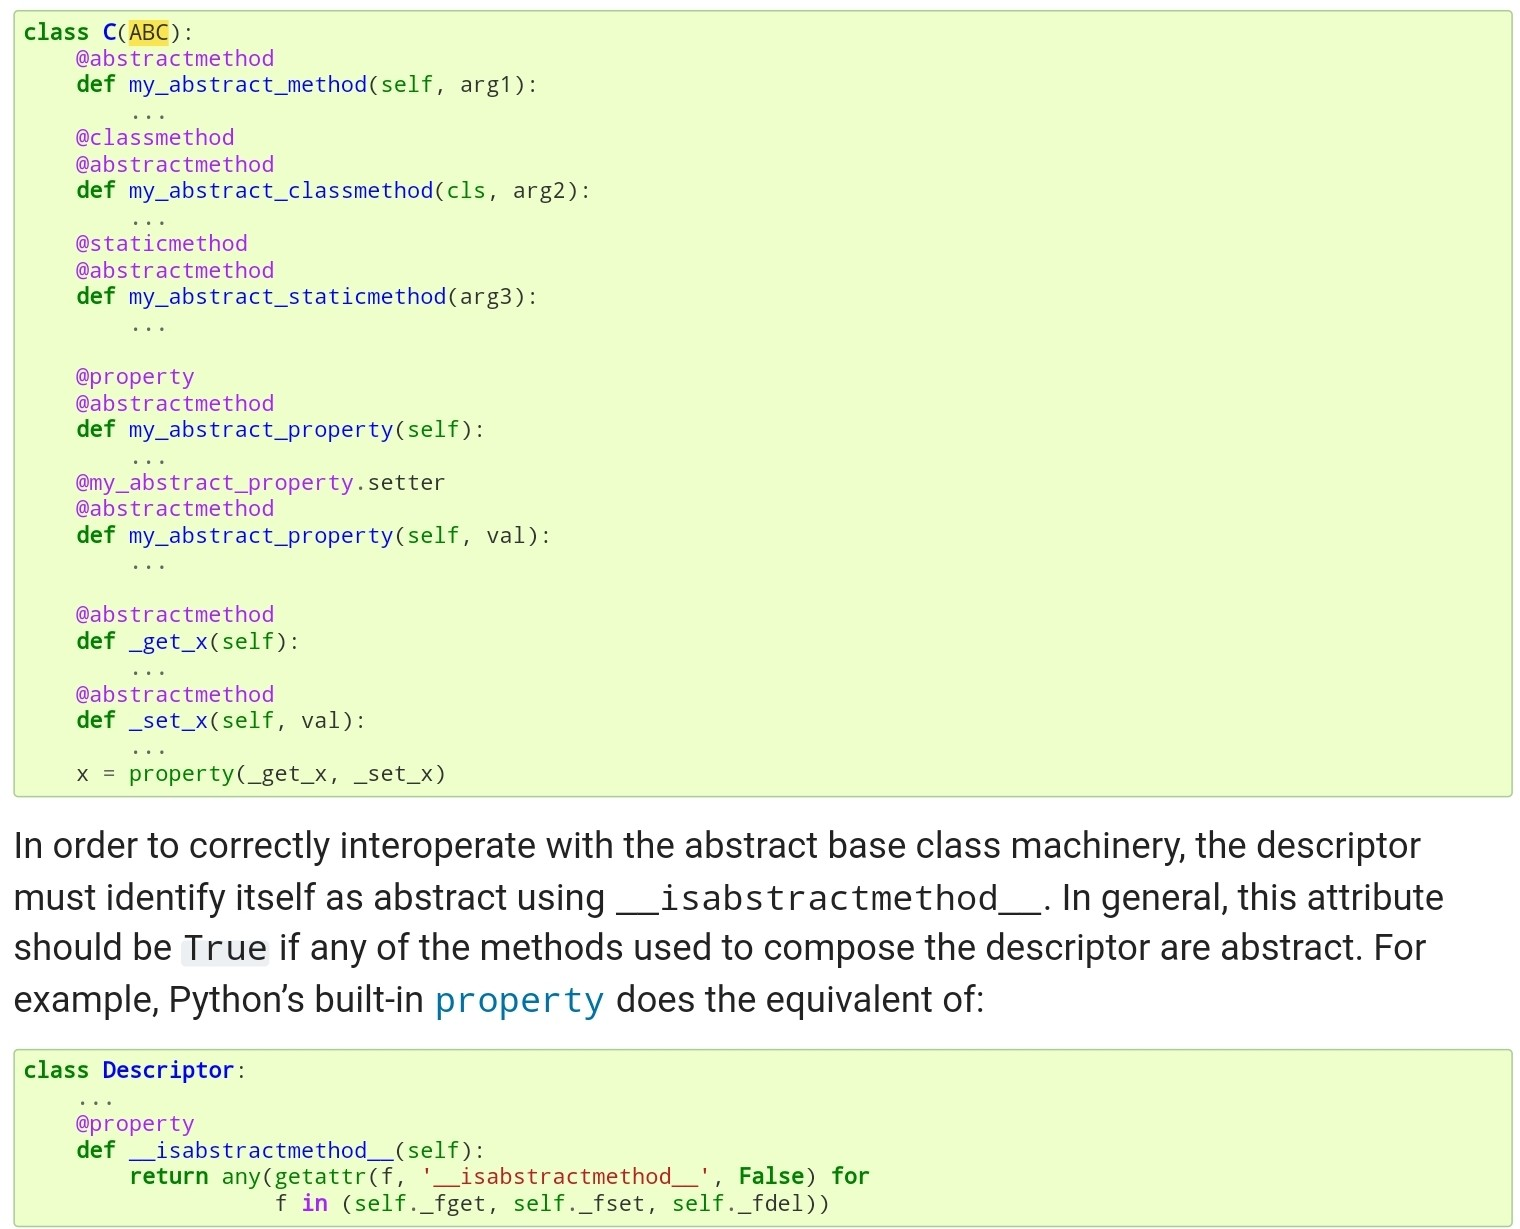

In [ ]:
class SectionBase(ABC):
    
    @abstractmethod
    def __init__(self, 
                 start_section: BreakOptions = None,
                 end_section: BreakOptions = None,
                 processor: ProcessorOptions = None,
                 assemble: AssembleCallableOptions = None,
                 name: str = 'Section',
                 #keep_partial: bool = False,
                 end_on_first_item: bool = False,
                 start_search: bool = None):
        super().__init__()
        self.context = None
        self.name= name
        self.source = None
        
    @abstractmethod
    def read(self, source: Source, start_search: bool = None,
             context: ContextType = None)->AssembledItem:
        return None


TODO Write a function to handle a list of objects containing .context and .name attributes and a .read() method

### Give subsections unique names so that the dictionary of section

In [ ]:
def section_naming(func):
    # Give subsections unique names so that the dictionary of section
    # reads won't loose anything.
    section_names = [sub_rdr.name for sub_rdr in func]
    unique_names = set(section_names)
    if len(unique_names) < len(section_names):
        renamed = list()
        for idx, sub_rdr in enumerate(func):
            name = sub_rdr.name
            new_name = name + str(idx)
            sub_rdr.name = new_name
            renamed.append(sub_rdr)
    else:
        renamed = func
    return renamed


### Tests whether methods in a list are Section objects.

In [ ]:
def is_sections(func_list):
    # Tests whether methods in a list are Section objects.
    is_sec = [isinstance(sub_rdr, SectionBase)
                for sub_rdr in func_list]
    return is_sec


In [ ]:

def is_all_sections(func):
    sec_check = all(
        isinstance(sub_rdr, SectionBase)
        for sub_rdr in func
        )
    return sec_check

In [ ]:
def set_subsection_reader(processing_def):
    # Look for individual subsections
    if isinstance(processing_def, SectionBase):
        read_func = partial(read_subsection, subsection=processing_def)
        # Indicate that this is a generator function for use by func_to_iter
        read_func.is_gen = True
        return read_func
    # Look for subsection groups
    if isinstance(processing_def, Tuple):
        # Tuples inside the list of processing methods should be all
        # sections.  Check if all item is the Tuple are type Section.
        if is_all_sections(processing_def):
            group_list = section_naming(processing_def)
            read_func = partial(read_subsection_groups,
                                section_list=group_list)
           # Indicate that this is a generator function for use by func_to_iter
            read_func.is_gen = True
            return read_func
        else:
            msg = ' '.join(['If a processing function is a tuple, all items in '
                            'the tuple must be Section Objects.'])
            raise ValueError(msg)
    # If processing_def is not a Section or Tuple of Sections return None
    return None


### Subsection processing function

In [ ]:

class ProcessingMethods():
    '''Applies a series of functions to a supplied sequence of items.

    Processing Methods combines a series of functions, generator functions,
    Rules, and/or Rule Sets (Processes) to produce a single generator function.
    The generator function will iterate through a supplied source of items
    returning the final processed item. The output type of each Process must
    match the expected input type of the next Process in the series.  No
    validation tests are done on this.

    A Process applied to a Source (a sequence of SourceItems) results in
    a sequence of ProcessedItems.  The relation between SourceItems and
    ProcessedItems is not necessarily 1:1.
       1 SourceItem ≠1 ProcessedItem;
    	  • 1 SourceItem → 1 ProcessedItem
    	  • 1 SourceItem → 2+ ProcessedItems
    	  • 2+ SourceItems → 1 ProcessedItem

    Generator functions are used when multiple input items are
    required to generate an output item, or when one SourceItem results in
    multiple ProcessedItems. In general, regular functions are used when there
    is a one-to-one correspondence between input item and output item.  RuleSets
    are used when the function that should be applied to the SourceItem(s)
    depends on the result of one or more tests (Triggers).  Individual Rules can
    be used when only a single Trigger is required (by using both the Pass and
    Fail methods of the Rule) or to modify some of the SourceItems while leaving
    others unchanged (by setting the Fail method to 'Original').  For Rules or
    RuleSets it is important that the output is of the same type regardless of
    whether the Trigger(s) pass or fail.

    Processing functions should accept one the following argument sets:
        func(item)
        func(item, ** context)
        func(item, context)
        func(item, [other(s),] ** context)

    Attributes:
        processing_methods (ProcessGroup): The sequence of Processes (functions,
            generator functions, Rules, and/or RuleSets) to be applied to a
            source.
        name (str): Reference label for the processing method.
            Defaults to 'Processor'

    Methods:
        process(self, item, context)->RuleResult:
        reader(self, buffered_source, context):
        read(self, buffered_source, context):
            a generator function, accepting a source text stream
                and yielding the processed text.
    '''
    def __init__(self, processing_methods: List[ProcessMethodOptions] = None,
                 name = 'Processor'):
        '''Applies a series of functions to a supplied sequence of items.

        Processing functions should accept one the following argument sets:
            func(item)
            func(item, ** context)
            func(item, context)
            func(item, [other(s),] ** context)

        Arguments:
            processing_methods (ProcessGroup): The sequence of Processes
                (functions, generator functions, Rules, and/or RuleSets) to be
                applied to the section source.
            name (str): Reference label for the processing method.
                Defaults to 'Processor'
        '''
        self.name = name
        if not processing_methods:
            return_item = lambda item, context: item
            return_item.is_gen = False
            self.processing_methods = [return_item]
        else:
            self.processing_methods = self.clean_methods(processing_methods)

    @staticmethod
    def clean_methods(processing_methods: ProcessMethodOptions)->ProcessMethodsList:
        '''Convert the supplied functions or action names to a function with
        the expected "Process Function" argument signature.

        The standard "Process Function" argument signature is:
            func(item: SourceOptions, context: ContextType)->ProcessedItems:

        In addition to correcting the argument signature, also identify any
        supplied function that are generator functions.

        Arguments:
            processing_methods (ProcessMethodOptions): A sequence of action
                names, functions, generator functions, Rules, and RuleSets to be
                applied to a source.

        Returns:
            ProcessMethodsList: The sequence of Processes with the correct
                argument signature.
        '''
        if not isinstance(processing_methods, List):
            processing_methods = [processing_methods]
        cleaned_methods = list()
        for func in processing_methods:
            subsection_func = set_subsection_reader(func)
            if subsection_func:
                cleaned_methods.append(subsection_func)            
            elif isinstance(func, (Rule, RuleSet)):
                cleaned_methods.append(func)
            else:
                cleaned_methods.append(set_method(func))
        return cleaned_methods

    @staticmethod
    def func_to_iter(source: Source, func: ProcessFunc,
                    context: ContextType = None)->ProcessedItemGen:
        '''Create a iterator that applies func to each item in source.

        If func is a generator function, return the iterator created by calling
        func with source.  Otherwise use a generator expression to return an
        iterator that returns the result of calling func on each item in source.
        No type checking is performed.

        context is not explicitly returned, but if supplied, items in context
        may be modified by func.

        Arguments:
            source (Source): An iterator that returns the appropriate data types
                for func.
            func (ProcessCallableOptions): A function Rule or RuleSet that
                can be applied to a Source.
            context (ContextType, optional): Contextual information to be used
                and / or set by func. Defaults to None.
        Returns:
            ProcessedItemGen: An iterator that returns the result of calling func
                on each item in source.
        '''
        def func_gen(source, context) -> Generator[ProcessedItem, None, None]:
            for item in source:
                yield from func(item, context)

        if not context:
            context = dict()
        if isinstance(func, (Rule, RuleSet)):
            return func_gen(source, context)
        # Test whether the function is a generator function as identified
        # earlier by the set_method function.
        if func.is_gen:
            return func(iter(source), context)
        return (func(item, context) for item in source)

    def reader(self, source: Source,
               context: ContextType = None)->ProcessedItemGen:
        '''A generator function that applies the ProcessingMethods to a given
        sequence.

        context is not explicitly returned, but if supplied, items in context
        may be modified by func.

        Arguments:
            source (Source): A sequence of items with a type matching that
                expected by the first of the series of processing methods.
            context (ContextType, optional): Additional information that can be
                accessed and / or set by the Process functions.
                Defaults to None.
        Yields:
            ProcessedItemGen: An iterator of the results of applying the
                process functions to the input source sequence.
        '''
        if not context:
            context = dict()
        next_source = source
        for func in self.processing_methods:
            next_source = self.func_to_iter(next_source, func, context)
        final_generator = iter(next_source)
        return final_generator

    def read(self, source: Source, context: ContextType = None)->ProcessedList:
        '''Iterate through the given sequence, applying the ProcessingMethods
        to each item in the source.

        Arguments:
            source (Source): A sequence of items with a type matching that
                expected by the first of the series of processing methods.
            context (ContextType, optional): Additional information that can be
                accessed and / or set by the Process functions.
                Defaults to None.
        Returns:
            ProcessedList: The results of applying the process functions to the
            input source sequence.
        '''
        process_gen = self.reader(source, context)
        processed_items = list()
        while True:
            try:
                processed_items.append(next(process_gen))
            except StopIteration:
                break
        return processed_items

    def process(self, item: SourceItem,
                context: ContextType = None)->ProcessOutput:
        '''Applies the ProcessingMethods to an individual item.

        If the process methods return a 1 SourceItem → 1 ProcessedItem result,
        return the single ProcessedItem, otherwise return a list of the
        resulting ProcessedItems.

        context is not explicitly returned, but if supplied, items in context
        may be modified by func.

        Arguments:
            item (SourceItem): An item with a type matching that expected by the
                first of the series of processing methods.
            context (ContextType, optional): Additional information that can be
                accessed and / or set by the Process functions.
                Defaults to None.
        Returns:
            ProcessOutput: The results of applying the process functions to the
            input item.
        '''
        if not context:
            context = dict()
        result = [item]
        for func in self.processing_methods:
            result = self.func_to_iter(iter(result), func, context)
        output = [item for item in result]
        if len(output) == 1:
            output = output[0]
        return output


In [ ]:

combined_sections = []
while True:
    section_group = {}
    for sub_section in section_list:
        sub_section_item = sub_section.read(test_iter)
        section_group[sub_section.name] = sub_section_item
    combined_sections.append(section_group)
    if sub_section.scan_status in ['Scan Complete', 'End of Source']:
        break
    


In [ ]:
name_section = Section(
    name='SingleSection',
    start_section=SectionBreak('StartSection', name='StartSection'),
    end_section=SectionBreak('EndSection', name='EndSection')
    )


In [ ]:
full_section = Section(
    name='Single Subsection',
    start_section=SectionBreak('StartSection', break_offset='Before'),
    end_section=SectionBreak('EndSection', break_offset='After'),
    processor=[name_section, content_section, end_section]
    )

In [ ]:
def set_context(item, context):
    name = context.get('Current Section')
    if name:                               
        context[name] = item
    else:
        context['No section'] = item
    return item


def print_context(item, context):
    pprint(context)
    return item


In [ ]:
name_section = Section(
    name='Name',
    end_section=SectionBreak(True, name='NameEnd'),
    processor=set_context
    )
content_section = Section(
    name='Content',
    end_section=SectionBreak('EndSection', break_offset='Before', name='EndContent'),
    processor=set_context
    )
end_section = Section(
    name='End',
    end_section=SectionBreak(True, name='EndEnd'),
    processor=print_context
    )


In [ ]:
full_section = Section(
    name='Full',
    start_section=SectionBreak('StartSection', break_offset='Before'),
    end_section=SectionBreak('EndSection', break_offset='After'),
    processor=[name_section, content_section, end_section]
    )

In [ ]:

section_list = [name_section, content_section, end_section]

test_context = {'dummy': 'Test'}

all_sections = []
while True:
    section_group = {}
    active_context = test_context
    for sub_section in section_list:
        sub_section_item = sub_section.read(test_iter, context = test_context)
        section_group[sub_section.name] = sub_section_item
        active_context = sub_section.context
    if sub_section.scan_status in ['Scan Complete', 'End of Source']:
        break
    all_sections.append(section_group)
    

print('test_context:\t', test_context,'\n')
print('all_sections')
pprint(all_sections, indent=4)

print('sub_section.context')
pprint(sub_section.context, indent=4)

In [ ]:
test_iter = BufferedIterator(multi_section_text)

section_list = [name_section, content_section, end_section]

test_context = {'dummy': 'Test'}



while True:
    section_group = {}
    for sub_section in section_list:
        sub_section_item = sub_section.read(test_iter, context = test_context)
        section_group[sub_section.name] = sub_section_item
        #pprint(sub_section.context)
        #print()
    pprint(section_group)
    if sub_section.scan_status in ['Scan Complete', 'End of Source']:
        break
pprint(sub_section.context)


## Single line subsections

In [ ]:
name_section = Section(
    name='Name',
    start_section=SectionBreak('StartSection', name='NameStart'),
    end_section=SectionBreak(True, name='NameEnd')
    )

content_section = Section(
    name='Content',
    end_section=SectionBreak('EndSection', 
                             break_offset='Before', 
                             name='EndContent')
    )

end_section = Section(
    name='End',
    end_section=SectionBreak(True, name='EndEnd')
    )


In [ ]:
section_list = (name_section, content_section, end_section)

subsection_group = ProcessingMethods(section_list)

full_section = Section(
    name='Full Section',
    processor=subsection_group
    )



In [ ]:
test_iter = BufferedIterator(multi_section_text)
context = {'dummy': 'asdf'}

full_section.read(test_iter)


In [ ]:

pprint(combined_sections)
print()
pprint(context)

#### Subsection definitions

In [ ]:
name_section = Section(
    name='Name',
    start_section=SectionBreak('Name', name='Name'),
    end_section=SectionBreak(True, name='EndName')
    )

content_section = Section(
    name='Content',
    end_section=SectionBreak('EndSection', 
                             break_offset='Before', 
                             name='EndContent')
    )

end_section = Section(
    name='End',
    end_section=SectionBreak(True, name='EndEnd')
    )

section_list = [name_section, content_section, end_section]


In [ ]:
from functools import partial
proc_func = partial(read_section_list, section_list)
test_context = {'dummy': 'Test'}

full_section = Section(
    name='Full Subsection',
    #start_section=SectionBreak('StartSection', break_offset='Before'),
    #end_section=SectionBreak('EndSection', break_offset='After'),
    processor=proc_func
    )

full_section.read(test_iter, start_search=False)

In [ ]:
read_section_list(section_list, test_iter)

In [ ]:

print(repr(test_iter))

## set_subsection_reader
``

Converts section instances to functions that call the section reader.

Args:<br>
> **processing_def (ProcessMethodDef):** A processing method.

Raises:<br>
>  **ValueError:** For processing instruction items which are lists where
        the list items are not all Section instances.

Returns:<br>
>  **ProcessMethodDef:** If processing_def is a section object, or a list
    of section objects, return a partial function that calls the
    section(s) read_subsections method.
    Otherwise returns processing_def.